# Modelo Predictivo del Precio del Oro 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import layers, callbacks

2025-12-01 18:33:42.527073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Se cargan los datos del oro desde un archivo CSV.
# En este caso se carga el dataset XAU/USD con intervalos de 1 hora (2016–2025).
df_AU = pd.read_csv('XAU_USD_2016-2025_01-12_1h_bars.csv')

# Para mostrar las primeras filas del DataFrame.
df_AU.head()


,UTC,Open,High,Low,Close,Volume
0,03.01.2016 23:00:00 UTC,1062.341,1066.321,1061.729,1063.059,1.61136
1,04.01.2016 00:00:00 UTC,1063.059,1064.740,1062.729,1064.459,2.77903
2,04.01.2016 07:00:00 UTC,1069.809,1073.052,1068.518,1071.321,3.45542
3,04.01.2016 05:00:00 UTC,1065.358,1068.949,1065.049,1068.659,3.96556
4,04.01.2016 06:00:00 UTC,1068.660,1070.119,1067.909,1069.801,2.40655


In [ ]:
# Se elimina el texto " UTC" de cada valor en la columna 'UTC'.
df_AU['UTC'] = df_AU['UTC'].str.replace(' UTC', '', regex=False)

# Se convierte la columna 'UTC', que originalmente es texto (tipo object),
# a un tipo de dato datetime usando el formato específico: DD.MM.YYYY HH:MM:SS.
# Esto permite manipular la columna como fechas reales.
df_AU['UTC'] = pd.to_datetime(df_AU['UTC'], format='%d.%m.%Y %H:%M:%S')

# Se establece la columna 'UTC' como índice del DataFrame.
df_AU = df_AU.set_index('UTC')

In [4]:
df_AU

,Open,High,Low,Close,Volume
UTC,,,,,
2016-01-03 23:00:00,1062.341,1066.321,1061.729,1063.059,1.61136
2016-01-04 00:00:00,1063.059,1064.740,1062.729,1064.459,2.77903
2016-01-04 07:00:00,1069.809,1073.052,1068.518,1071.321,3.45542
2016-01-04 05:00:00,1065.358,1068.949,1065.049,1068.659,3.96556
2016-01-04 06:00:00,1068.660,1070.119,1067.909,1069.801,2.40655
...,...,...,...,...,...
2025-11-21 20:00:00,4087.365,4088.495,4054.955,4067.098,3.64090
2025-11-23 23:00:00,4070.098,4077.285,4064.745,4074.905,1.19017
2025-11-24 02:00:00,4043.805,4051.385,4040.375,4043.345,1.35411


In [ ]:
# Se asegura que el índice del DataFrame sea de tipo datetime.
df = df_AU.copy()
df.index = pd.to_datetime(df.index)

# Se cuentan las observaciones registradas por día,
# tomando como referencia la columna 'Close' y agrupando por días (resample diario).
counts = df['Close'].resample('D').count()

# Se define el número esperado de registros por día (24 horas).
expected_per_day = 24

# Se construye un nuevo DataFrame para almacenar la cantidad real de datos por día
# y calcular cuántos registros faltan respecto al total esperado.
avail = pd.DataFrame({'count': counts})
avail['missing'] = expected_per_day - avail['count']

# Se muestra un resumen del análisis de disponibilidad de datos.
print("Total días:", len(avail))
print("Días con 24 horas:", (avail['count'] == expected_per_day).sum())
print("Días incompletos (<24 horas):", (avail['count'] < expected_per_day).sum())

# Se visualizan los primeros 10 días del resumen.
display(avail.head(10))




Total días: 3614
Días con 24 horas: 0
Días incompletos (<24 horas): 3614


,count,missing
UTC,,
2016-01-03,1,23
2016-01-04,23,1
2016-01-05,23,1
2016-01-06,23,1
2016-01-07,23,1
2016-01-08,22,2
2016-01-09,0,24
2016-01-10,1,23
2016-01-11,23,1


In [ ]:
# Para conocer el rango de fechas y días faltantes, en caso de haberlos.
start = df.index.min()
end = df.index.max()
print(f"Rango de datos: {start}  ->  {end}")

total_days = (end - start).days + 2  # incluir ambos extremos
print("Días totales en el rango:", total_days)


Rango de datos: 2016-01-03 23:00:00  ->  2025-11-24 02:00:00
Días totales en el rango: 3614


In [ ]:
# Se realiza un remuestreo del DataFrame a frecuencia diaria ('D'),
# agregando las columnas financieras siguiendo las reglas típicas de OHLCV.
df_daily = df.resample('D').agg({
    'Open': 'first',   # El precio de apertura del día corresponde al primer valor registrado.
    'High': 'max',     # El precio máximo del día se toma como el valor más alto observado.
    'Low': 'min',      # El precio mínimo del día se toma como el valor más bajo observado.
    'Close': 'last',   # El precio de cierre del día corresponde al último valor registrado.
    'Volume': 'sum',   # El volumen diario se obtiene sumando todos los volúmenes horarios.
})

df_daily

,Open,High,Low,Close,Volume
UTC,,,,,
2016-01-03,1062.341,1066.321,1061.729,1063.059,1.61136
2016-01-04,1063.059,1083.488,1062.239,1072.979,76.56875
2016-01-05,1072.990,1082.048,1072.629,1077.632,72.43959
2016-01-06,1077.632,1095.180,1074.928,1092.559,77.55685
2016-01-07,1092.559,1110.080,1091.350,1109.210,94.99869
...,...,...,...,...,...
2025-11-20,4104.265,4109.805,4038.605,4078.675,63.94997
2025-11-21,4078.665,4100.839,4022.075,4064.279,63.53061
2025-11-22,NaN,NaN,NaN,NaN,0.00000


In [ ]:
# Se aplican valores del día anterior (forward fill) 
# con el fin de completar días en los que falta información después del remuestreo.
# Esta técnica garantiza continuidad en la serie temporal y evita valores NaN.
df_daily[['Open','High','Low','Close']] = df_daily[['Open','High','Low','Close']].ffill()

df_daily

,Open,High,Low,Close,Volume
UTC,,,,,
2016-01-03,1062.341,1066.321,1061.729,1063.059,1.61136
2016-01-04,1063.059,1083.488,1062.239,1072.979,76.56875
2016-01-05,1072.990,1082.048,1072.629,1077.632,72.43959
2016-01-06,1077.632,1095.180,1074.928,1092.559,77.55685
2016-01-07,1092.559,1110.080,1091.350,1109.210,94.99869
...,...,...,...,...,...
2025-11-20,4104.265,4109.805,4038.605,4078.675,63.94997
2025-11-21,4078.665,4100.839,4022.075,4064.279,63.53061
2025-11-22,4078.665,4100.839,4022.075,4064.279,0.00000


In [9]:
df_daily.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

#  Modelo LSTM

El modelo LSTM (Long Short-Term Memory) es un tipo de red neuronal diseñada especialmente para trabajar con datos que cambian en el tiempo, como series financieras, señales o lenguaje. A diferencia de las redes recurrentes tradicionales, que suelen “olvidar” información cuando las secuencias son largas, las LSTM incorporan un mecanismo de memoria que les permite recordar patrones importantes durante más tiempo.

La idea central es que, cuando un modelo intenta predecir una serie temporal, no solo necesita ver el punto inmediatamente anterior, a veces los eventos pasados, incluso lejanos, influyen en lo que ocurrirá después. Las LSTM fueron creadas para manejar justamente ese tipo de dependencias.

Una LSTM utiliza una estructura interna compuesta por “puertas”, que actúan como filtros capaces de decidir cuánta información debe recordarse, cuánta debe olvidarse y cuánta debe actualizarse en cada paso. Estas puertas funcionan de manera análoga a interruptores que se activan o desactivan según lo que convenga al aprendizaje [1,2].

## Componentes Principales

1. Puerta de Olvido (Forget)    → Decide qué información descartar
2. Puerta de Entrada (Input)    → Decide qué nueva información guardar
3. Puerta de Salida (Output)    → Decide qué información pasa al output

En conjunto, estas tres puertas permiten que la LSTM mantenga una “memoria regulada”, recordando solo lo necesario y olvidando lo que dejó de ser útil. Gracias a este mecanismo, este tipo de red es especialmente eficaz para predecir series financieras como el precio del oro, donde las tendencias pasadas influyen en el presente, pero no toda la información histórica es igual de importante [1,2].

In [ ]:
# Se divide el conjunto de datos en entrenamiento y prueba según el año.
# El conjunto de entrenamiento incluye datos desde 2016 hasta 2023 (ambos inclusive).
train = df_daily[
    (df_daily.index.year <= 2023) & (df_daily.index.year >= 2016)
]

# El conjunto de prueba incluye únicamente los datos posteriores a 2023.
test = df_daily[(df_daily.index.year > 2023)]


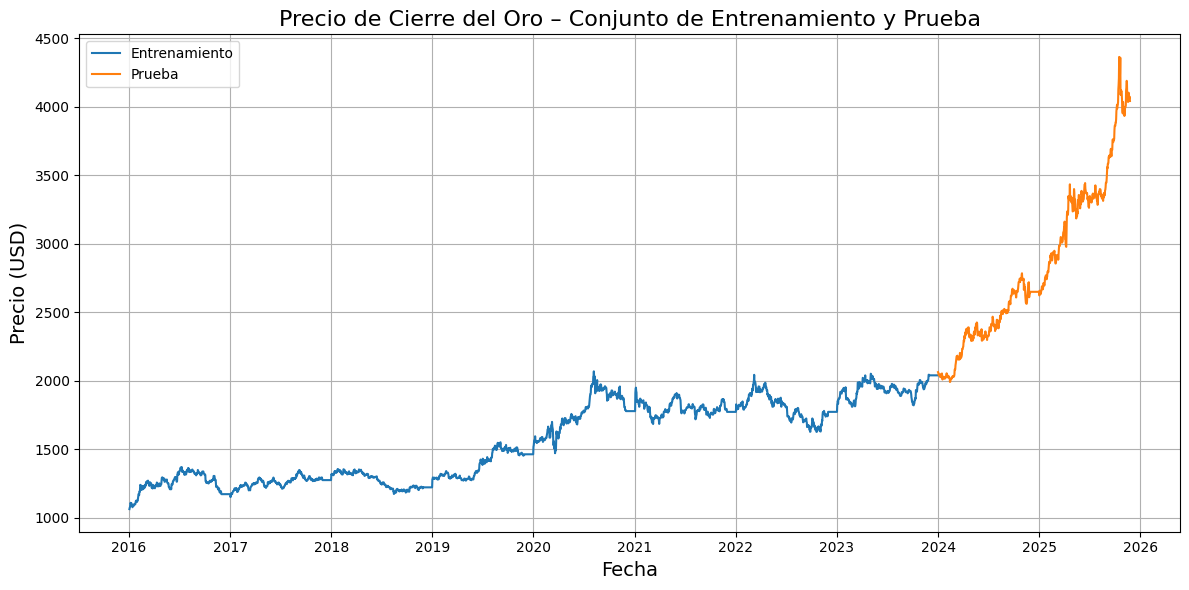

In [11]:
plt.figure(figsize=(12,6))

plt.plot(train['Close'], label='Entrenamiento')
plt.plot(test['Close'], label='Prueba')

plt.title('Precio de Cierre del Oro – Conjunto de Entrenamiento y Prueba', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio (USD)', fontsize=14)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
train

,Open,High,Low,Close,Volume
UTC,,,,,
2016-01-03,1062.341,1066.321,1061.729,1063.059,1.61136
2016-01-04,1063.059,1083.488,1062.239,1072.979,76.56875
2016-01-05,1072.990,1082.048,1072.629,1077.632,72.43959
2016-01-06,1077.632,1095.180,1074.928,1092.559,77.55685
2016-01-07,1092.559,1110.080,1091.350,1109.210,94.99869
...,...,...,...,...,...
2023-12-27,2044.605,2047.118,2031.258,2040.005,0.00000
2023-12-28,2044.605,2047.118,2031.258,2040.005,0.00000
2023-12-29,2044.605,2047.118,2031.258,2040.005,0.00000


In [13]:
test

,Open,High,Low,Close,Volume
UTC,,,,,
2024-01-01,2062.598,2066.595,2062.405,2063.615,0.467980
2024-01-02,2063.625,2078.825,2055.818,2059.455,28.260549
2024-01-03,2059.475,2065.835,2030.515,2042.895,29.198980
2024-01-04,2042.865,2050.855,2036.155,2044.098,20.914870
2024-01-05,2044.128,2063.838,2024.255,2045.355,32.129880
...,...,...,...,...,...
2025-11-20,4104.265,4109.805,4038.605,4078.675,63.949970
2025-11-21,4078.665,4100.839,4022.075,4064.279,63.530610
2025-11-22,4078.665,4100.839,4022.075,4064.279,0.000000


In [ ]:
# Se aplica un escalado Min-Max a los valores de cierre del conjunto de entrenamiento,
# normalizándolos en el rango [0, 1]. Esto es importante para el correcto funcionamiento
# de redes neuronales como LSTM, que son sensibles a la escala de los datos.
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train['Close'].values.reshape(-1,1))

# Se crean las ventanas temporales necesarias para entrenar la LSTM.
# Cada muestra de entrada (X_train) contiene 85 días previos de precios escalados,
# mientras que la etiqueta correspondiente (y_train) es el precio del día siguiente.
X_train, y_train = [], []

for i in range(85, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-85:i, 0])  # Secuencia de 85 días.
    y_train.append(training_set_scaled[i, 0])       # Valor objetivo: día actual.

# Se convierten las listas a arreglos NumPy para ser utilizados por el modelo.
X_train = np.array(X_train)
y_train = np.array(y_train)

# Se ajustan las dimensiones de X_train al formato requerido por LSTM:
# (n_muestras, pasos_temporales, n_features), donde n_features = 1.
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))



In [ ]:
# Se construye un modelo secuencial basado en LSTM para la predicción de series temporales.
model = Sequential([

    # Primera capa LSTM con 256 unidades. Se utiliza 'return_sequences=True'
    # para que la capa devuelva toda la secuencia y pueda conectarse con otra LSTM.
    LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    
    # Capa Dropout para reducir sobreajuste, desactivando aleatoriamente el 20% de las neuronas.
    layers.Dropout(0.2),
    
    # Segunda capa LSTM con 128 unidades, también devolviendo secuencias para la siguiente capa.
    layers.LSTM(units=128, return_sequences=True),
    layers.Dropout(0.2),
    
    # Tercera capa LSTM con 64 unidades. Esta capa ya no devuelve secuencia completa, solo el último estado.
    layers.LSTM(units=64),
    layers.Dropout(0.2),
    
    # Capa de salida densa con una sola unidad para predecir el valor del precio escalado.
    layers.Dense(units=1)
])

# Se compila el modelo utilizando el optimizador Adam y la función de pérdida MSE,
# junto con métricas comunes para evaluar el rendimiento en series temporales.
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])


/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 85, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 85, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 85, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 85, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,785 (1.95 MB)

 Trainable params: 510,785 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Se define un callback de Early Stopping para detener el entrenamiento de forma anticipada
# si la pérdida deja de mejorar. El parámetro 'patience=5' indica que se toleran hasta 5 épocas
# sin mejora significativa. 'min_delta=0.001' establece el mínimo cambio requerido para considerarse mejora.
# 'restore_best_weights=True' permite recuperar los mejores pesos obtenidos durante el entrenamiento.
early_stopping = callbacks.EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)

# Se entrena el modelo LSTM utilizando las ventanas creadas. 
# Se especifican 32 épocas y un tamaño de batch de 32 muestras por iteración.
# El callback de early stopping se pasa para controlar el sobreentrenamiento.
history = model.fit(X_train, y_train, epochs=32, batch_size=32, callbacks=[early_stopping])

# Se guarda el modelo entrenado en formato Keras, permitiendo cargarlo posteriormente.
model.save('modelo_lstm_oro_.keras')


Epoch 1/32
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.0122 - mae: 0.0681 - mape: 15.3314 - mse: 0.0122
Epoch 2/32
 2/89 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0041 - mae: 0.0417 - mape: 9.6682 - mse: 0.0041

/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0031 - mae: 0.0398 - mape: 8.6315 - mse: 0.0031
Epoch 3/32
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0028 - mae: 0.0382 - mape: 8.4025 - mse: 0.0028
Epoch 4/32
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0031 - mae: 0.0405 - mape: 8.8668 - mse: 0.0031
Epoch 5/32
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0034 - mae: 0.0419 - mape: 8.9605 - mse: 0.0034
Epoch 6/32
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0025 - mae: 0.0361 - mape: 7.7683 - mse: 0.0025
Epoch 7/32
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0028 - mae: 0.0382 - mape: 8.1310 - mse: 0.0028
Epoch 8/32
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0024 - mae: 0.0347 - mape: 7.3556 - mse: 0.0024
Epoch 9/32
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0023 - mae: 0.0343 - mape: 7.3216 - mse: 0.0023
Epoch 10/32
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0026 - mae: 0.0360 - mape: 7.6015 - mse: 0.0026
Epoch 11/32
89/89 ━━━━━━━━━━━

In [51]:
history_frame = pd.DataFrame(history.history)

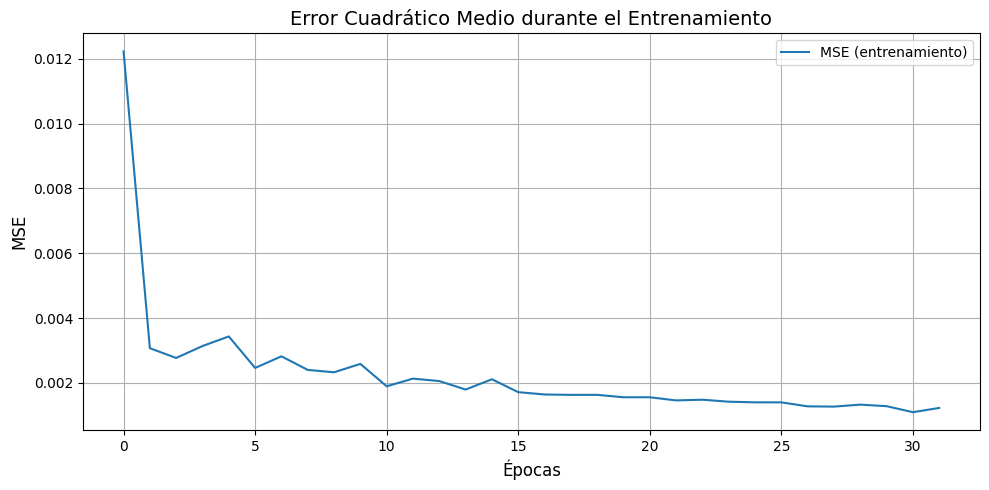

In [52]:
plt.figure(figsize=(10,5))

plt.plot(history_frame['mse'], label='MSE (entrenamiento)')

plt.title('Error Cuadrático Medio durante el Entrenamiento', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('MSE', fontsize=12)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Se toma la serie completa de precios de cierre desde el DataFrame diario.
dataset_total = df_daily['Close']

# Se construye el vector de entrada para las predicciones del modelo.
# Para generar las ventanas de 85 días necesarias, se extraen los últimos valores
# correspondientes al conjunto de prueba, más los 85 días previos.
inputs = dataset_total[len(dataset_total) - len(test['Close'].values) - 85:].values

# Se redimensiona el arreglo para que tenga el formato adecuado (una sola columna),
# ya que el MinMaxScaler y el modelo esperan este tipo de estructura.
inputs = inputs.reshape(-1, 1)

# Se aplica el mismo escalado Min-Max utilizado durante el entrenamiento,
# garantizando que los datos de predicción estén en la misma escala que los de entrenamiento.
inputs = sc.transform(inputs)


In [ ]:
# Se crea la lista que contendrá las ventanas temporales para realizar las predicciones.
x_test = []
for i in range(85, len(inputs)):
    # Para cada posición, se toman los 85 valores anteriores como secuencia de entrada.
    x_test.append(inputs[i-85:i, 0])

# Se convierte la lista en un arreglo NumPy para poder usarlo con el modelo.
x_test = np.array(x_test)

# Se ajusta la forma del arreglo al formato requerido por la LSTM:
# (n_muestras, pasos_temporales, n_features), donde n_features = 1.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Se realiza la predicción del precio utilizando el modelo entrenado.
predicted_price = model.predict(x_test)

# Se revierte el escalado Min-Max para volver a la escala real de precios.
predicted_price = sc.inverse_transform(predicted_price)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [ ]:
# Se crea un DataFrame para almacenar los valores reales y los valores predichos.
predictions = pd.DataFrame()

# Se asignan los valores reales de cierre provenientes del conjunto de prueba.
predictions["Actuals"] = test['Close']  # Valor real del precio.

# Se agregan las predicciones generadas por el modelo LSTM.
predictions['Predictions'] = predicted_price  # Valor predicho por el modelo.


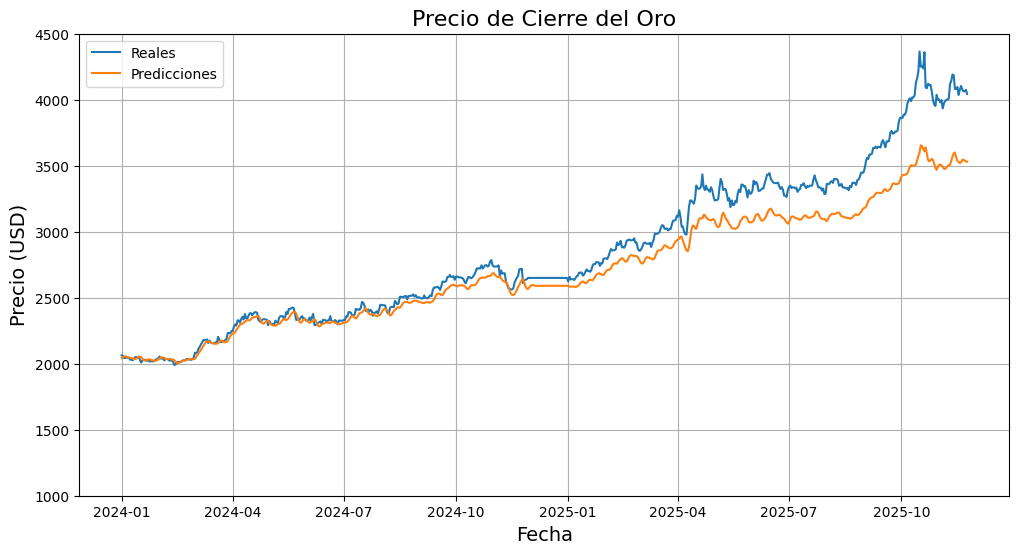

In [59]:
plt.figure(figsize=(12,6))

plt.plot(predictions['Actuals'], label= 'Reales')
plt.plot(predictions['Predictions'], label= 'Predicciones')
plt.title('Precio de Cierre del Oro', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio (USD)', fontsize=14)
plt.legend()
plt.ylim(1000,4500)
plt.grid()
plt.show()

In [ ]:
# Se calculan las métricas de desempeño del modelo comparando valores reales vs. predichos.

# Error cuadrático medio (RMSE): mide la magnitud promedio del error,
# penalizando más los errores grandes.
rmse = np.sqrt(mean_squared_error(predictions['Actuals'], predictions['Predictions']))

# Error absoluto medio (MAE): mide la diferencia promedio absoluta entre predicción y realidad.
mae = mean_absolute_error(predictions['Actuals'], predictions['Predictions'])

# Coeficiente de determinación (R2): indica qué proporción de la variabilidad
# de los valores reales es explicada por el modelo.
r2 = r2_score(predictions['Actuals'], predictions['Predictions'])

# Error porcentual absoluto medio (MAPE): mide el error relativo en porcentaje.
# Es útil para interpretar el error respecto al valor real.
mape = np.mean(np.abs((predictions['Actuals'] - predictions['Predictions']) / predictions['Actuals'])) * 100

# Se imprimen los resultados con formato.
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.44f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 score: {r2:.4f}")


RMSE: 209.1122
MAE: 142.5834
MAPE: 4.27%
R2 score: 0.8696


El modelo LSTM muestra un buen entendimiento de la tendencia general del precio del oro, algo que se refleja en su R² de 0.87, indicando que capta gran parte del comportamiento de la serie. También logra un MAPE del 4.27%, que significa que, en promedio, el error relativo no es muy alto. Sin embargo, cuando se mira el error en dólares, el panorama cambia: un RMSE de unos 209 USD y un MAE de 142 USD muestran que, aunque el modelo sigue bien la forma general de la curva, puede equivocarse por más de cien dólares al predecir un valor puntual. Esto vuelve el modelo útil para analizar si la tendencia va al alza o a la baja, pero no lo hace suficientemente preciso para predicciones exactas o decisiones de trading delicadas. En resumen, entiende la tendencia, pero todavía no tiene la precisión necesaria para acertar el precio exacto del oro día a día.

## Entrenamiento del modelo con múltiples características

In [ ]:
# Se seleccionan múltiples características para el entrenamiento del modelo.
# En este caso se utilizan el precio de cierre y el volumen negociado.
train_multi_features = train[['Close', 'Volume']]

# Se crea un objeto MinMaxScaler para escalar ambas características al rango [0, 1].
sc_multi = MinMaxScaler(feature_range=(0, 1))

# Se ajusta el escalador a los datos de entrenamiento y luego se transforman,
# obteniendo un conjunto escalado adecuado para el modelo multivariable.
training_set_scaled_multi = sc_multi.fit_transform(train_multi_features)



In [ ]:
# Se crean las listas que almacenarán las ventanas de entrada (x) y los valores objetivo (y)
# para el modelo multivariable.
x_train_multi = []
y_train_multi = []

# Se generan secuencias de 85 días de historial para cada muestra.
# Cada ventana contiene dos características: 'Close' y 'Volume'.
for i in range(85, len(training_set_scaled_multi)):
    # Se añade al conjunto de entrada la ventana de 85 filas y todas las columnas (características).
    x_train_multi.append(training_set_scaled_multi[i-85:i, :])
    
    # El valor objetivo es el precio de cierre (columna 0) en el día actual i.
    y_train_multi.append(training_set_scaled_multi[i, 0])

# Se convierten las listas en arreglos NumPy, formato requerido por las redes LSTM.
x_train_multi, y_train_multi = np.array(x_train_multi), np.array(y_train_multi)


In [ ]:
# Se construye un modelo LSTM para el caso multivariable, utilizando varias capas
# recurrentes y de regularización por dropout.

model_multi = Sequential([
    
    # Primera capa LSTM con 256 unidades. Se especifica return_sequences=True
    # para permitir el apilado de capas LSTM posteriores.
    # La entrada tiene forma: (ventana temporal, número de características).
    LSTM(units=256, return_sequences=True,
         input_shape=(x_train_multi.shape[1], x_train_multi.shape[2])),

    # Capa Dropout para reducir sobreajuste, apagando el 20% de las neuronas.
    layers.Dropout(0.2),

    # Segunda capa LSTM con 128 unidades, también devolviendo secuencias.
    layers.LSTM(units=128, return_sequences=True),
    layers.Dropout(0.2),

    # Tercera capa LSTM con 64 unidades. Esta ya no devuelve secuencias.
    layers.LSTM(units=64),
    layers.Dropout(0.2),

    # Capa densa final con una única neurona para predecir el precio de cierre.
    layers.Dense(units=1)
])

# Se compila el modelo indicando el optimizador Adam, la función de pérdida MSE
# y tres métricas adicionales de evaluación.
model_multi.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse', 'mae', 'mape']
)



/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stopping_multi = callbacks.EarlyStopping(
    patience = 5,        # Espera hasta 5 épocas sin mejora antes de detener el entrenamiento
    min_delta=0.001,     # Considera que hubo mejora solo si la pérdida baja al menos 0.001
    restore_best_weights=True   # Al terminar, recupera automáticamente los mejores pesos del modelo
)

# Entrena el modelo con los datos multivariados (Close y Volume)
history_multi = model_multi.fit(
    x_train_multi,
    y_train_multi,
    epochs=30,           # Máximo de 30 épocas (aunque puede parar antes por early stopping)
    batch_size=32,       # Entrena en lotes de 32 muestras
    callbacks=[early_stopping_multi]  # Activa early stopping para evitar sobreentrenamiento
)

# Guarda el modelo entrenado en un archivo, para cargarlo después sin tener que reentrenar
model.save('modelo_multi_lstm_oro_.keras')



Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0104 - mae: 0.0626 - mape: 14.1022 - mse: 0.0104
Epoch 2/30
 2/89 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0025 - mae: 0.0364 - mape: 9.7938 - mse: 0.0025

/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0032 - mae: 0.0414 - mape: 9.0482 - mse: 0.0032
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0030 - mae: 0.0390 - mape: 8.4036 - mse: 0.0030
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0029 - mae: 0.0388 - mape: 8.4347 - mse: 0.0029
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0031 - mae: 0.0404 - mape: 8.8390 - mse: 0.0031
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0024 - mae: 0.0354 - mape: 7.7035 - mse: 0.0024
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0023 - mae: 0.0346 - mape: 7.5568 - mse: 0.0023
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0023 - mae: 0.0346 - mape: 7.4534 - mse: 0.0023
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0022 - mae: 0.0337 - mape: 7.2122 - mse: 0.0022
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0021 - mae: 0.0333 - mape: 7.1148 - mse: 0.0021
Epoch 11/30
89/89 ━━━━━━━━━━━

In [ ]:
# Se seleccionan del conjunto de prueba únicamente las columnas utilizadas por el modelo (Close y Volume).
test_multi_features = test[['Close', 'Volume']]

# Se convierten estos datos a un arreglo NumPy para facilitar su procesamiento.
inputs_multi = test_multi_features.values

# Se aplica el mismo escalador ajustado con los datos de entrenamiento, garantizando coherencia en la transformación.
inputs_multi = sc_multi.transform(inputs_multi)

# Se construyen las secuencias de entrada para el modelo, cada una con una ventana de 85 días.
x_test_multi = []
for i in range(85, len(inputs_multi)):
    # Para cada posición, se toman los 85 valores previos de Close y Volume como entrada.
    x_test_multi.append(inputs_multi[i-85:i, :])

# Finalmente, se convierte la lista resultante en un arreglo NumPy para que pueda ser procesado por el modelo.
x_test_multi = np.array(x_test_multi)




/home/dayana-henao/Escritorio/PredicticModel/Dayana/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# El modelo realiza las predicciones usando las secuencias generadas para el conjunto de prueba.
predicted_stock_price_multi_scaled = model_multi.predict(x_test_multi)

# Como el escalador fue ajustado con dos características (Close y Volume),
# es necesario reconstruir una matriz con ambas columnas para aplicar la transformación inversa.
# En este caso, la segunda columna (Volume) no es relevante para la predicción,
# por lo que se crea una columna ficticia llena de ceros con la misma cantidad de filas.
dummy_volume_column = np.zeros(predicted_stock_price_multi_scaled.shape)

# Se combinan las predicciones escaladas con la columna ficticia,
# de modo que la matriz tenga la misma estructura que la usada durante el entrenamiento.
predictions_combined = np.concatenate((predicted_stock_price_multi_scaled, dummy_volume_column), axis=1)

# Se aplica la transformación inversa del escalador,
# recuperando los valores originales en la escala real del precio del oro.
# Luego se selecciona únicamente la columna correspondiente al precio (Close).
predicted_stock_price_multi = sc_multi.inverse_transform(predictions_combined)[:, 0]

# Se construye un DataFrame para comparar los valores reales y las predicciones del modelo multivariable.
# Los valores reales se alinean con el tamaño de las secuencias generadas.
predictions_multi = pd.DataFrame()
predictions_multi["Actuals"] = test['Close'].iloc[len(inputs_multi) - len(x_test_multi):]
predictions_multi["Predictions"] = predicted_stock_price_multi




20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


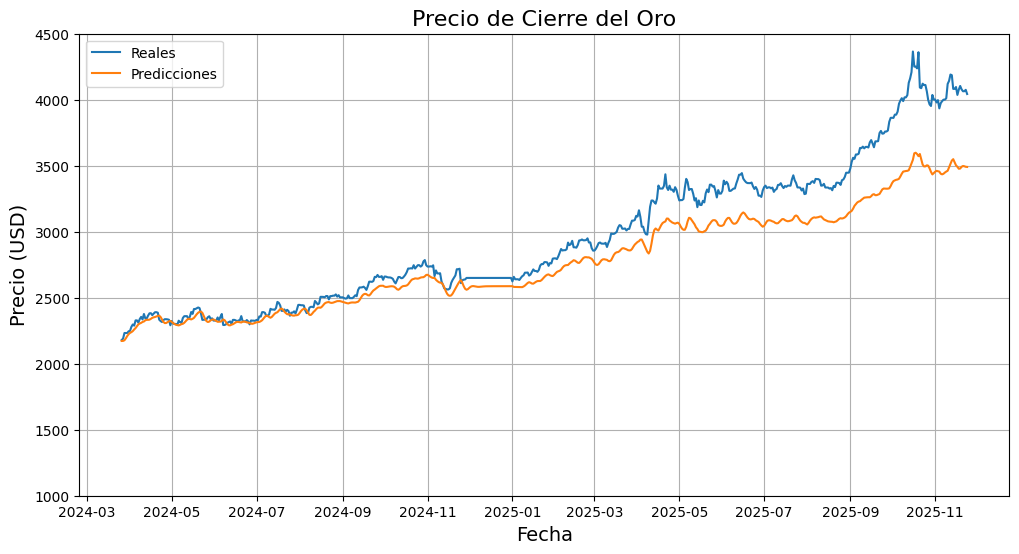

In [85]:
plt.figure(figsize=(12,6))
plt.title('Precio de Cierre del Oro', fontsize=16)
plt.plot(predictions_multi['Actuals'], label= 'Reales')
plt.plot(predictions_multi['Predictions'], label= 'Predicciones')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio (USD)', fontsize=14)
plt.ylim(1000,4500)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Se calcula la métrica RMSE (Root Mean Squared Error), que mide la magnitud promedio
# del error entre los valores reales y las predicciones. Un RMSE bajo indica mejor desempeño.
rmse = np.sqrt(mean_squared_error(predictions_multi['Actuals'], predictions_multi['Predictions']))

# Se calcula la métrica MAE (Mean Absolute Error), que evalúa el error absoluto promedio
# entre los valores reales y los estimados. Es una medida más interpretable al no penalizar
# fuertemente los errores grandes.
mae = mean_absolute_error(predictions_multi['Actuals'], predictions_multi['Predictions'])

# Se calcula el coeficiente R², que mide qué tan bien el modelo logra explicar la variabilidad
# de los datos reales. Un valor cercano a 1 indica que el modelo tiene un buen nivel de ajuste.
r2 = r2_score(predictions_multi['Actuals'], predictions_multi['Predictions'])

# Se calcula el MAPE (Mean Absolute Percentage Error), que expresa el error en términos porcentuales,
# lo cual permite interpretar la precisión del modelo en relación con el valor real.
mape = np.mean(np.abs((predictions_multi['Actuals'] - predictions_multi['Predictions']) / predictions_multi['Actuals'])) * 100

# Se imprimen todas las métricas con un formato organizado para facilitar su lectura.
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 score: {r2:.4f}")


RMSE: 244.0811
MAE: 175.9159
MAPE: 5.22%
R2 score: 0.7914


Los resultados del modelo multivariado muestran que, aunque se agregó una segunda característica (el volumen), el desempeño empeoró en comparación con el modelo que usaba únicamente el precio de cierre. El RMSE y el MAE aumentaron de forma notable, lo que indica que los errores absolutos y cuadrados crecieron. El MAPE también subió, pasando de alrededor del 4.27% al 5.22%, lo que significa que las predicciones son proporcionalmente menos precisas. Además, el R² cayó a 0.79, mostrando que el modelo explica menos variabilidad del precio real del oro.

Esto demuestra que el modelo con más características no necesariamente aprende mejor, y en este caso, el volumen parece no aportar información útil para predecir el precio futuro del oro a una escala diaria.

## Conclusiones 

El modelo predictivo basado en redes LSTM logró aprender bastante bien cómo se había comportado históricamente el precio del oro. Mostró un MAPE relativamente bajo y un R² alto, lo que indica que sí entendió los patrones del pasado. Sin embargo, cuando se observan métricas como el RMSE y el MAE, se nota que los errores absolutos siguen siendo altos, lo cual refleja que, aunque el modelo captura la tendencia general, tiene dificultades para aproximarse con precisión a los valores reales.

La causa principal parece estar en la naturaleza de los datos. Al observar la gráfica que separa el conjunto de entrenamiento y el de prueba, se puede observar que entre 2016 y 2023 el precio del oro tuvo un crecimiento moderado y bastante estable, mientras que en el período de prueba aparece una subida abrupta y completamente distinta al comportamiento histórico. Ese salto tan fuerte representa un cambio que no depende de las variables utilizadas, y por lo tanto es algo que ningún modelo puede anticipar solo a partir de datos pasados.

Básicamente, el modelo aprendió de datos estables, pero se le pidió predecir un escenario completamente diferente. Aun así, el modelo logró seguir de forma razonable la dirección de la tendencia, aunque no alcanzó la magnitud real del incremento.

### Nota:

Para el desarrollo de este trabajo se utilizó ChatGPT [3] como apoyo para la aclaración de dudas puntuales, sugerencias de mejora del código y mejoras en la redacción.

## Bibliografía 

[1] Codificando Bits. (s. f.). ¿Qué son las Redes LSTM? Codificando Bits. https://codificandobits.com/blog/redes-lstm/
 
[2] GeeksforGeeks. (2025, octubre 7). What is LSTM – Long Short Term Memory? GeeksforGeeks. https://www.geeksforgeeks.org/deep-learning/deep-learning-introduction-to-long-short-term-memory/

[3] OpenAI. (2025). ChatGPT (versión GPT-5.1) [Modelo de lenguaje AI]. Recuperado de https://chat.openai.com/